## **CLV and RFM Seg** 

Scott

2020- 06- 12



# Know the Metrics - Exploring the Data

In [34]:
from __future__ import division
from datetime import datetime, timedelta
import pandas as pd
%matplotlib inline
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [27]:
! curl https://www.dropbox.com/s/4kb9c0xy84i1obv/data_retail.csv?dl=1 -O -J -L

% Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:33 --:--:--     0^C


In [35]:
retail_data = pd.read_csv("Section 6 Project Dataset_ data_retail.csv")
retail_data

,invoice_no,quantity,invoice_date,unit_price,customer_id,cogs,country
0,536365,1,12/1/2010 8:26,326,17850,156.48,United Kingdom
1,536365,2,12/1/2010 8:26,349,17850,132.62,United Kingdom
2,536365,1,12/1/2010 8:26,334,17850,123.58,United Kingdom
3,536365,1,12/1/2010 8:26,207,17850,72.45,United Kingdom
4,536365,2,12/1/2010 8:26,230,17850,80.50,United Kingdom
...,...,...,...,...,...,...,...
273113,548134,2,7/21/2011 9:30,466,21572,172.42,United Kingdom
273114,549461,2,7/21/2011 9:31,390,21002,191.10,United Kingdom
273115,532726,2,7/21/2011 9:31,334,18907,160.32,United Kingdom
273116,547665,2,7/21/2011 9:31,311,21122,155.50,United Kingdom


In [36]:
# Calcualate Revenue
retail_data['invoice_date'] = pd.to_datetime(retail_data['invoice_date'])

retail_data['invoice_year_month'] = retail_data['invoice_date'].map(lambda date: 100*date.year + date.month)

retail_data['revenue'] = retail_data['unit_price'] * retail_data['quantity']
revenue = retail_data.groupby(['invoice_year_month'])['revenue'].sum().reset_index()
revenue

,invoice_year_month,revenue
0,201012,22340103
1,201101,18458630
2,201102,14594349
3,201103,19280648
4,201104,15690864
5,201105,19444110
6,201106,19327663
7,201107,14292149


## Calculate the Metrics

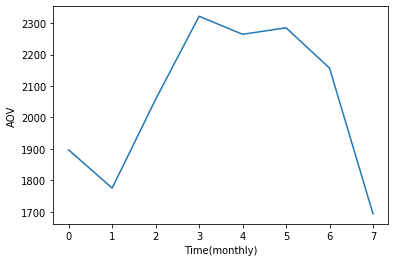

In [37]:
# Calculate the AVO 
g = retail_data.groupby(['invoice_year_month'])
reve = g['revenue'].sum() 
no = g['invoice_no'].nunique()
AOV = reve / no
AOV.values
# plot the trend (monthly)
plt.figure()
plt.plot(AOV.values)
plt.xlabel("Time(monthly)")
plt.ylabel("AOV")
plt.show()

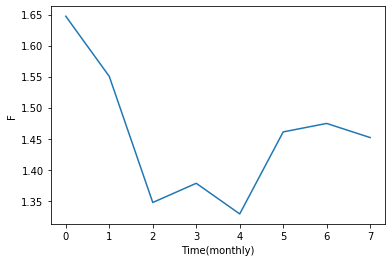

In [38]:
# Calculate the purchase frequency
g = retail_data.groupby(['invoice_year_month'])
total_order = g['invoice_no'].nunique() 
total_cid = g['customer_id'].nunique()
F = total_order / total_cid
F.values
# plot the trend (monthly)
plt.figure()
plt.plot(F.values)
plt.xlabel("Time(monthly)")
plt.ylabel("F")
plt.show()

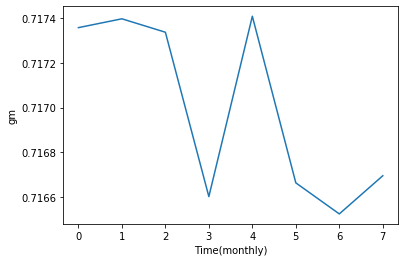

In [39]:
# Calculate the GM
g = retail_data.groupby(['invoice_year_month'])
reve = g['revenue'].sum() 
cogs = g['cogs'].sum()
gm = (reve - cogs) / reve
gm.values
# plot the trend (monthly)
plt.figure()
plt.plot(gm.values)
plt.xlabel("Time(monthly)")
plt.ylabel("gm")
plt.show()

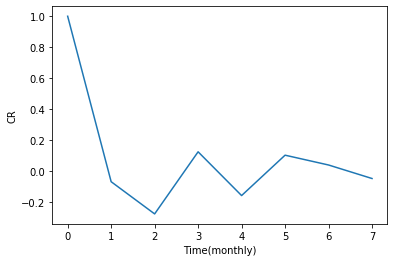

In [40]:
# Calculate the Churn Rate
g = retail_data.groupby(['invoice_year_month'])
c_num = g['customer_id'].nunique()
temp_1 = list(c_num.values)
temp_2 = list(c_num.values)
del temp_1[-1]
temp_1.insert(0,0)
temp_lost = np.array(temp_2) - np.array(temp_1)
CR = temp_lost / temp_2
CR
# plot the trend (monthly)
plt.figure()
plt.plot(CR)
plt.xlabel("Time(monthly)")
plt.ylabel("CR")
plt.show()

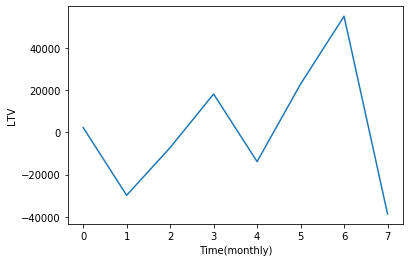

In [41]:
# Calculate the LTV
LTV = AOV * F * gm / CR
LTV
# plot the trend (monthly)
plt.figure()
plt.plot(LTV.values)
plt.xlabel("Time(monthly)")
plt.ylabel("LTV")
plt.show()

# RFM Segmentation

In [42]:
# Recency
user_seg = pd.DataFrame(retail_data['customer_id'].unique())
user_seg.columns = ['customer_id']

max_purchase = retail_data.groupby('customer_id').invoice_date.max().reset_index()
max_purchase.columns = ['customer_id','max_purchase_date']

max_purchase['recency'] = (max_purchase['max_purchase_date'].max() - max_purchase['max_purchase_date']).dt.days

user_seg = pd.merge(user_seg, max_purchase[['customer_id','recency']], on='customer_id')
user_seg.head()

,customer_id,recency
0,17850,160
1,13047,12
2,12583,12
3,13748,90
4,15100,188


In [43]:
# Frequency
frequency = retail_data.groupby('customer_id').invoice_date.count().reset_index()
frequency.columns = ['customer_id','frequency']
user_seg = pd.merge(user_seg, frequency, on = 'customer_id')
user_seg.head()

,customer_id,recency,frequency
0,17850,160,312
1,13047,12,131
2,12583,12,136
3,13748,90,13
4,15100,188,6


In [44]:
#Revenue
revenue = retail_data.groupby('customer_id').revenue.sum().reset_index()
revenue.columns = ['customer_id','revenue']
user_seg = pd.merge(user_seg, revenue, on = 'customer_id')
user_seg.head()

,customer_id,recency,frequency,revenue
0,17850,160,312,163393
1,13047,12,131,71917
2,12583,12,136,74480
3,13748,90,13,7038
4,15100,188,6,3161


/home/bf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/bf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/bf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

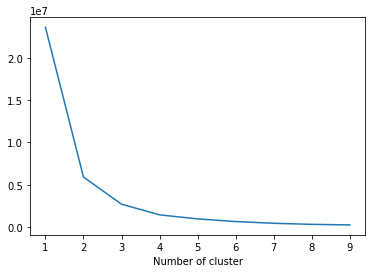

In [45]:
#Elbow Method
sse={}
recency = user_seg[['recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(recency)
    recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [54]:
#K means cluster based on recency
kmeans = KMeans(n_clusters=4)
kmeans.fit(user_seg[['recency']])
user_seg['recency_cluster'] = kmeans.predict(user_seg[['recency']])

user_seg.groupby('recency_cluster').mean()

user_seg[['recency']]

,recency
0,160
1,12
2,12
3,90
4,188
...,...
9975,0
9976,0
9977,0
9978,0


/home/bf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/bf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/bf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

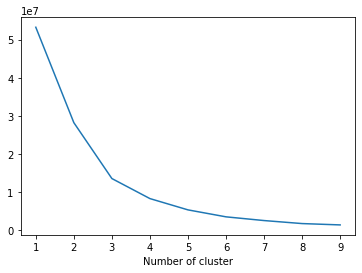

,customer_id,recency,frequency,revenue,recency_cluster,revenue_cluster
frequency_cluster,,,,,,
0,15413.753846,29.158974,217.069231,113667.276923,0.748718,1.953846
1,14897.272727,3.636364,1529.909091,806332.636364,0.000000,1.181818
2,19784.308801,35.201691,17.917528,9419.419459,0.707798,0.001462


In [62]:
# Apply the same method to Frequency and Revenue
# for frequency
sse={}
frequency = user_seg[['frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(frequency)
    frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

kmeans = KMeans(n_clusters=3)
kmeans.fit(user_seg[['frequency']])
user_seg['frequency_cluster'] = kmeans.predict(user_seg[['frequency']])

user_seg.groupby('frequency_cluster').mean()

/home/bf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/bf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/bf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

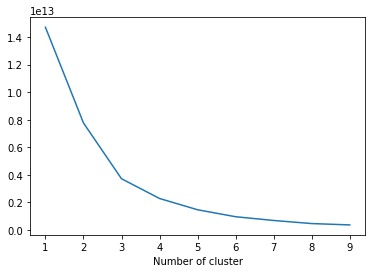

,customer_id,recency,frequency,revenue,recency_cluster,frequency_cluster
revenue_cluster,,,,,,
0,19778.200417,35.210943,18.092340,9506.571443,0.708181,1.996040
1,14606.000000,1.333333,1668.000000,879491.555556,0.000000,1.000000
2,15387.875000,28.585106,224.760638,117812.603723,0.736702,0.021277


In [64]:
#for revenue
sse={}
revenue = user_seg[['revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=5000).fit(revenue)
    revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

kmeans = KMeans(n_clusters=3)
kmeans.fit(user_seg[['revenue']])
user_seg['revenue_cluster'] = kmeans.predict(user_seg[['revenue']])

user_seg.groupby('revenue_cluster').mean()

# (Optional) KMeans from scratch

In [29]:
import numpy as np
import sys,math
from scipy.spatial import distance
import matplotlib.pyplot as plt

class KMeans_self:
    
    def __init__(self, k, eps):
        '''
        init a Kmeans cluster
        :param k: number of clusters
        :param eps: convergence limit
        '''
        self.k = k
        self.eps = eps
    
    
    def fit(self, x, detailed = False):
        '''
        fit for dataset x
        :param x: dataset input, should be np.ndarray
        :param detailed: boolean for print out or not
        :return: the label of each x
        '''
        '''
        algorithm overview:
        1. assigned the k centers randomly
        2.1 assigned the other points to cluster which has the minimum distance
        2.2 calculate the centers again by using the center of each clusters
        3. loop till changes less than eps
        '''
        if not isinstance(x, np.ndarray):
            x = np.array(x)
        n_samples = x.shape[0]
        '''assign the k centers randomly'''
        centers_idx = np.random.randint(n_samples, size=self.k)
        self.centers = x[centers_idx]
        '''step 2, loop till part'''
        stopped = False
        label = None
        
        '''2.1 calculate the distance pairs'''
        
        ite = 0
        while(ite < 40):  
            # contain labels
            samples_idx = []
            # contain classes
            for i in centers_idx:
                samples_idx.append([i])
            for i in range(n_samples):
                if i not in centers_idx:
                    dis = []
                    # calculate min distance to decide which class
                    for j in centers_idx:
                        dis.append(dist(x[i],x[j]))
                    min_id = dis.index(min(dis))
                    samples_idx[min_id].append(i)
            centers_idx = find_center(x,samples_idx)
            ite = ite + 1
        label = samples_idx
        
        return label
    
    def predict(self, x_new):
        '''
        predict module for kmeans, used for predict the cluster label for new x_new
        :param x_new: new data point
        :return: the label
        '''
        assert x_new.shape[1] == self.centers.shape[1], 'the dim of x_new should be the same as x/centers, centers dim: {}'.format(self.centers.shape[1])
        distance_matrix = distance.cdist(x_new, self.centers)
        predicted = np.argmin(distance_matrix, axis=1)
        return predicted

def dist(x,y):
    su = 0
    for i in range(x.shape[0]):
        su = su + (x[i] - y[i])**2
    
    return math.sqrt(su)

def find_center(x,idx):
    cid = []
    dist = []
    # for every class
    for cls in idx:
        dis = sys.maxsize
        ci = 0
        # for 
        mean_val = []
        for i in cls:
            mean_val.append(x[i])
        m = sum(mean_val) / len(mean_val)
        for i in cls:
            one_dis = distance.cdist([x[i]],[m])
            #print(x[i])
            if (dis > one_dis):
                ci = i
                dis = one_dis
        cid.append(i)
    
        dist.append(dis)
    
    return cid

In [30]:
class test:
    
    def __init__(self):
        pass
    '''only used for test for some module'''
    def test_scipy(self):
        '''test for scipy distance module'''
        print(scipy.__version__)
        from scipy.spatial import distance
        a = np.array([[0, 0, 0],
                      [0, 0, 1],
                      [0, 1, 0],
                      [0, 1, 1],
                      [1, 0, 0],
                      [1, 0, 1],
                      [1, 1, 0],
                      [1, 1, 1]])
        b = np.array([[0, 0, 0],
                      [0, 0, 1],
                      [0, 1, 0],
                      [0, 1, 1]])
        print(distance.cdist(a, b))
        print(np.argmin(distance.cdist(a, b), axis=1)) # [0 1 2 3 0 1 2 3]
        print(np.argmin(distance.cdist(a, b), axis=0)) # [0 1 2 3]
        print(distance.cdist(a, b).shape) # shape of a, shape of b
    
    def test_fit(self, x, k, eps):
        '''test for predict module'''
        kmeans = KMeans_self(k, eps)
        labels = kmeans.fit(x)
        print(labels)
    
    def test_predict(self, x, k, eps, x_new):
        kmeans = KMeans_self(k, eps)
        _ = kmeans.fit(x)
        predicted = kmeans.predict(x_new)
        print(predicted)
        

In [31]:

import matplotlib.pyplot as plt
np.random.seed(3)
unit_test = test()
x = np.random.randn(90, 6)
k, eps = 8, 1e-2
labels = unit_test.test_fit(x, k, eps)
a = x[:,0]
b = x[:,1]

[[80, 17, 28, 31, 50, 56, 72], [88, 16, 45, 47, 49, 53, 54, 55, 61, 64, 67, 89], [86, 3, 7, 20, 23, 29, 63, 68], [75, 1, 4, 6, 8, 11, 18, 19, 21, 22, 24, 27, 32, 33, 36, 38, 40, 71, 73, 74, 76, 79, 85], [65, 58, 59, 77, 87], [62, 0, 46, 66, 83], [84, 2, 5, 10, 12, 13, 14, 15, 25, 26, 30, 34, 35, 37, 39, 42, 43, 44, 51, 60, 69, 70, 78, 81, 82], [57, 9, 41, 48, 52]]


In [32]:
# run the KMeans

np.random.seed(3)
unit_test = test()
x = np.random.randn(20, 4)
k, eps = 3, 1e-2
unit_test.test_fit(x, k, eps)
x_new = np.random.randn(15, 4)
x_new2 = np.random.randn(10, 3)
try:
    unit_test.test_predict(x, k, eps, x_new2)
except Exception as e:
    print(e)
unit_test.test_predict(x, k, eps, x_new)

[[14, 0], [16, 1, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 18], [19, 2, 7, 15, 17]]
the dim of x_new should be the same as x/centers, centers dim: 4
[2 0 0 0 0 0 1 2 0 2 2 2 2 2 0]


Test on our user segementation data

In [21]:
import time
#K means cluster based on recency, using KMeans we write ourselves
start_time = time.time()
kmeans = KMeans_self(k=4, eps = 1)
kmeans.fit(user_seg[['recency']])
user_seg['recency_cluster'] = kmeans.predict(user_seg[['recency']])
elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time:0.4f} seconds")
user_seg.groupby('recency_cluster').mean()

NameError: name 'distance' is not defined

Compare with the result from Sklearn kmeans clustering

In [22]:
#K means cluster based on recency, using KMeans from sklearn package
kmeans = KMeans(n_clusters=4)
kmeans.fit(user_seg[['recency']])
user_seg['recency_cluster'] = kmeans.predict(user_seg[['recency']])

user_seg.groupby('recency_cluster').mean()

,customer_id,recency,frequency,revenue
recency_cluster,,,,
0,18421.940416,51.878583,30.566048,16065.170883
1,16264.056180,114.649189,27.317104,14424.583021
2,20580.922689,10.408048,26.809606,14065.904659
3,15420.663812,197.695931,23.531049,12367.385439


Last two questions before you leave:
1. Why the result from KMeans_self is different from the sklearn kmeans. 
- Hint: initialization part
2. How to improve the runtime efficiency
- Hint: smart initialization, K-D tree 